## Feature extraction with colour histograms

In [2]:
import pickle
import numpy as np
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity

# set working directory to paul

# get current working directory
print(os.getcwd())
dataset_path = "data/cifar-10-batches-py"


# install sklearn
# pip install -U scikit-learn

/Users/paulbojan/Documents/TU Wien/2.Semester/Machine Learning/assignments/ex3/ml-ex3/paul


In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def extract_color_histogram(image, bins=(16, 16, 16), color_space='LAB'):
    if color_space == 'HSV':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LAB':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    else:
        raise ValueError(f"Unsupported color space: {color_space}")

    hist = cv2.calcHist([converted_image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def load_cifar10_dataset(dataset_path, bins=(16, 16, 16), color_space='LAB'):
    data = []
    labels = []
    images = []
    for batch in range(1, 6):
        batch_file = os.path.join(dataset_path, f'data_batch_{batch}')
        batch_data = unpickle(batch_file)
        for image, label in zip(batch_data[b'data'], batch_data[b'labels']):
            image = image.reshape(3, 32, 32).transpose(1, 2, 0)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            hist = extract_color_histogram(image, bins=bins, color_space=color_space)
            data.append(hist)
            labels.append(label)
            images.append(image)
    return np.array(data), np.array(labels), images

dataset_path = "data/cifar-10-batches-py"

# 
bins = (8, 8, 8)  # Increase the number of bins 
color_space = 'HSV'  # LAB HSV 

data, labels, images = load_cifar10_dataset(dataset_path, bins=bins, color_space=color_space)

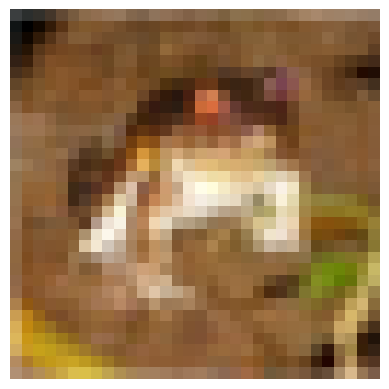

In [4]:
import matplotlib.pyplot as plt
import cv2

def display_image(image_data):
    # images has (3, 32, 32) (RGB) -> (32, 32, 3)
    image = image_data.reshape(3, 32, 32).transpose(1, 2, 0)
    # Convert from RGB to BGR for OpenCV display
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 
batch_file = os.path.join(dataset_path, 'data_batch_1')
batch_data = unpickle(batch_file)
first_image = batch_data[b'data'][0]

display_image(first_image)


### Exploring Histograms

In [5]:
# Import plt 
import matplotlib.pyplot as plt

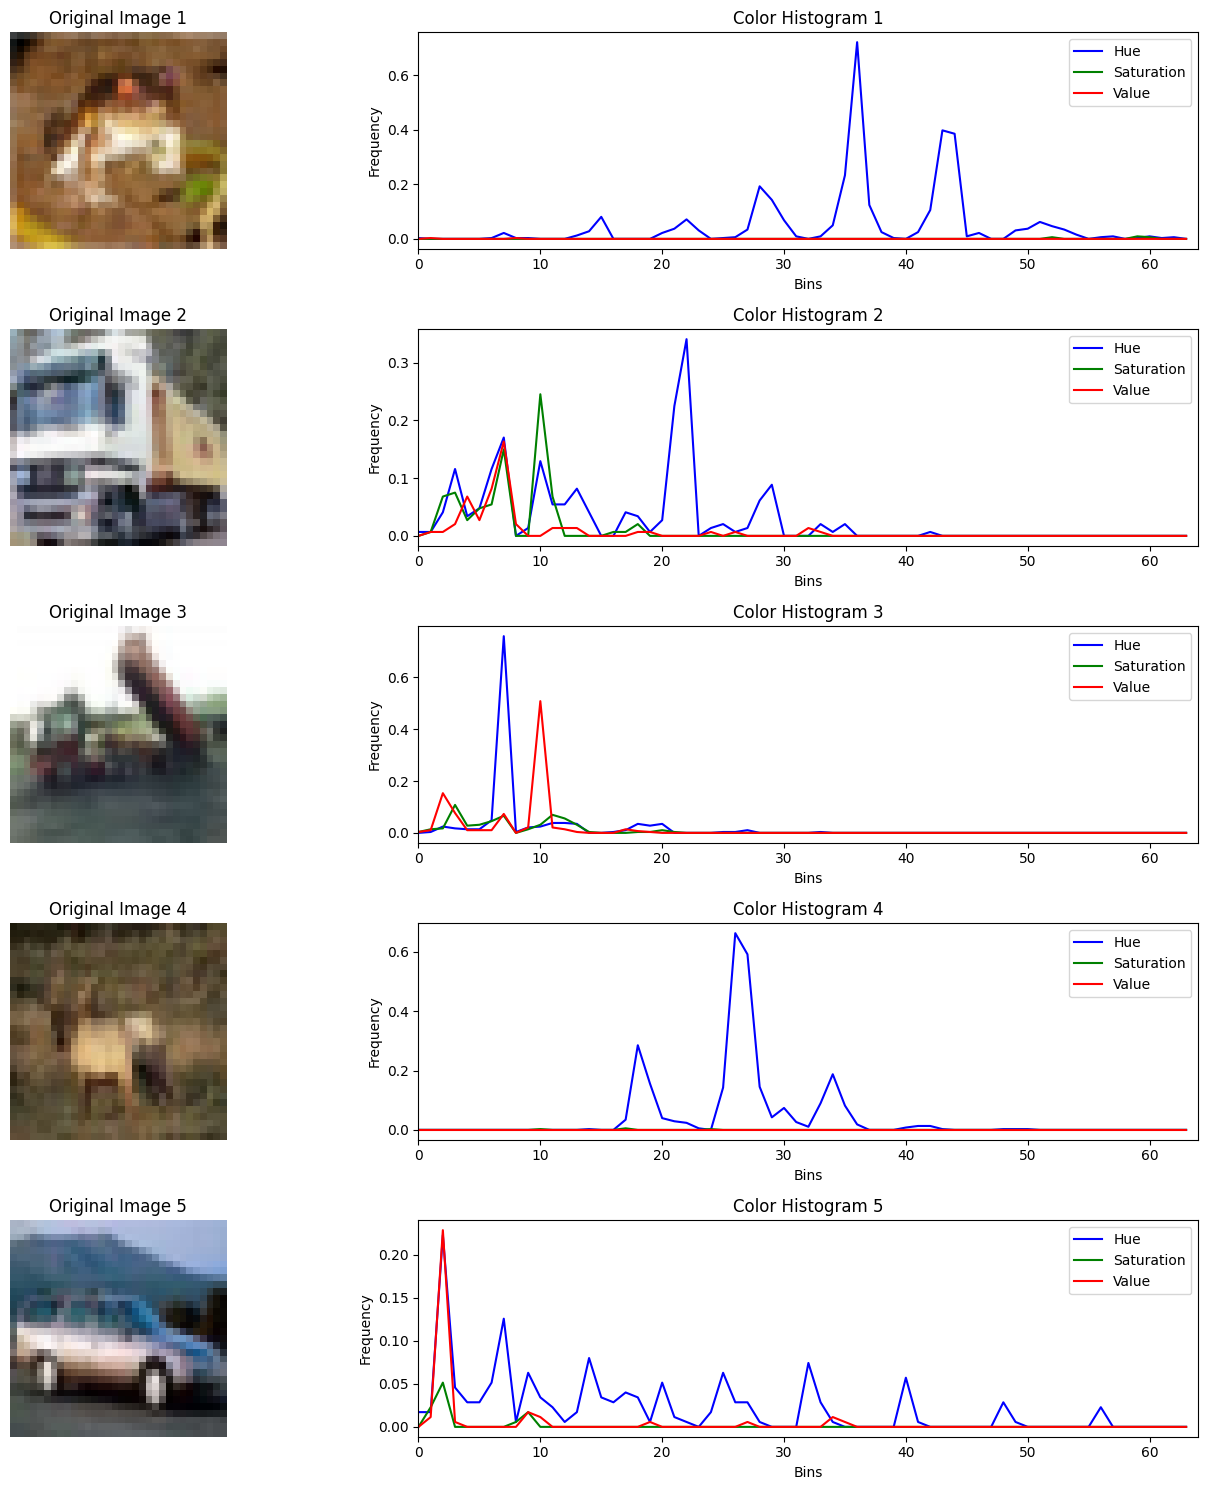

In [12]:
def plot_images_and_histograms(images, bins=(8, 8, 8), color_space='LAB'):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image {i+1}")
        plt.axis('off')
        
        # Calculate colour histogram
        hist = extract_color_histogram(image, bins=bins, color_space=color_space)
        
        # Plot histogram 
        plt.subplot(5, 2, 2 * i + 2)
        colors = ('b', 'g', 'r')
        labels = ('Hue', 'Saturation', 'Value') if color_space == 'HSV' else ('Channel 1', 'Channel 2', 'Channel 3')
        for j, (col, label) in enumerate(zip(colors, labels)):
            hist_part = hist[j * bins[0] * bins[1]: (j + 1) * bins[0] * bins[1]]
            plt.plot(hist_part, color=col, label=label)
            plt.xlim([0, bins[0] * bins[1]])
        
        plt.title(f"Color Histogram {i+1}")
        plt.xlabel("Bins")
        plt.ylabel("Frequency")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Select five example images
example_images = images[:5]

# Plot images and histograms
#bins = (8, 8, 8)
plot_images_and_histograms(example_images, bins=bins, color_space='HSV')

###  Similarity

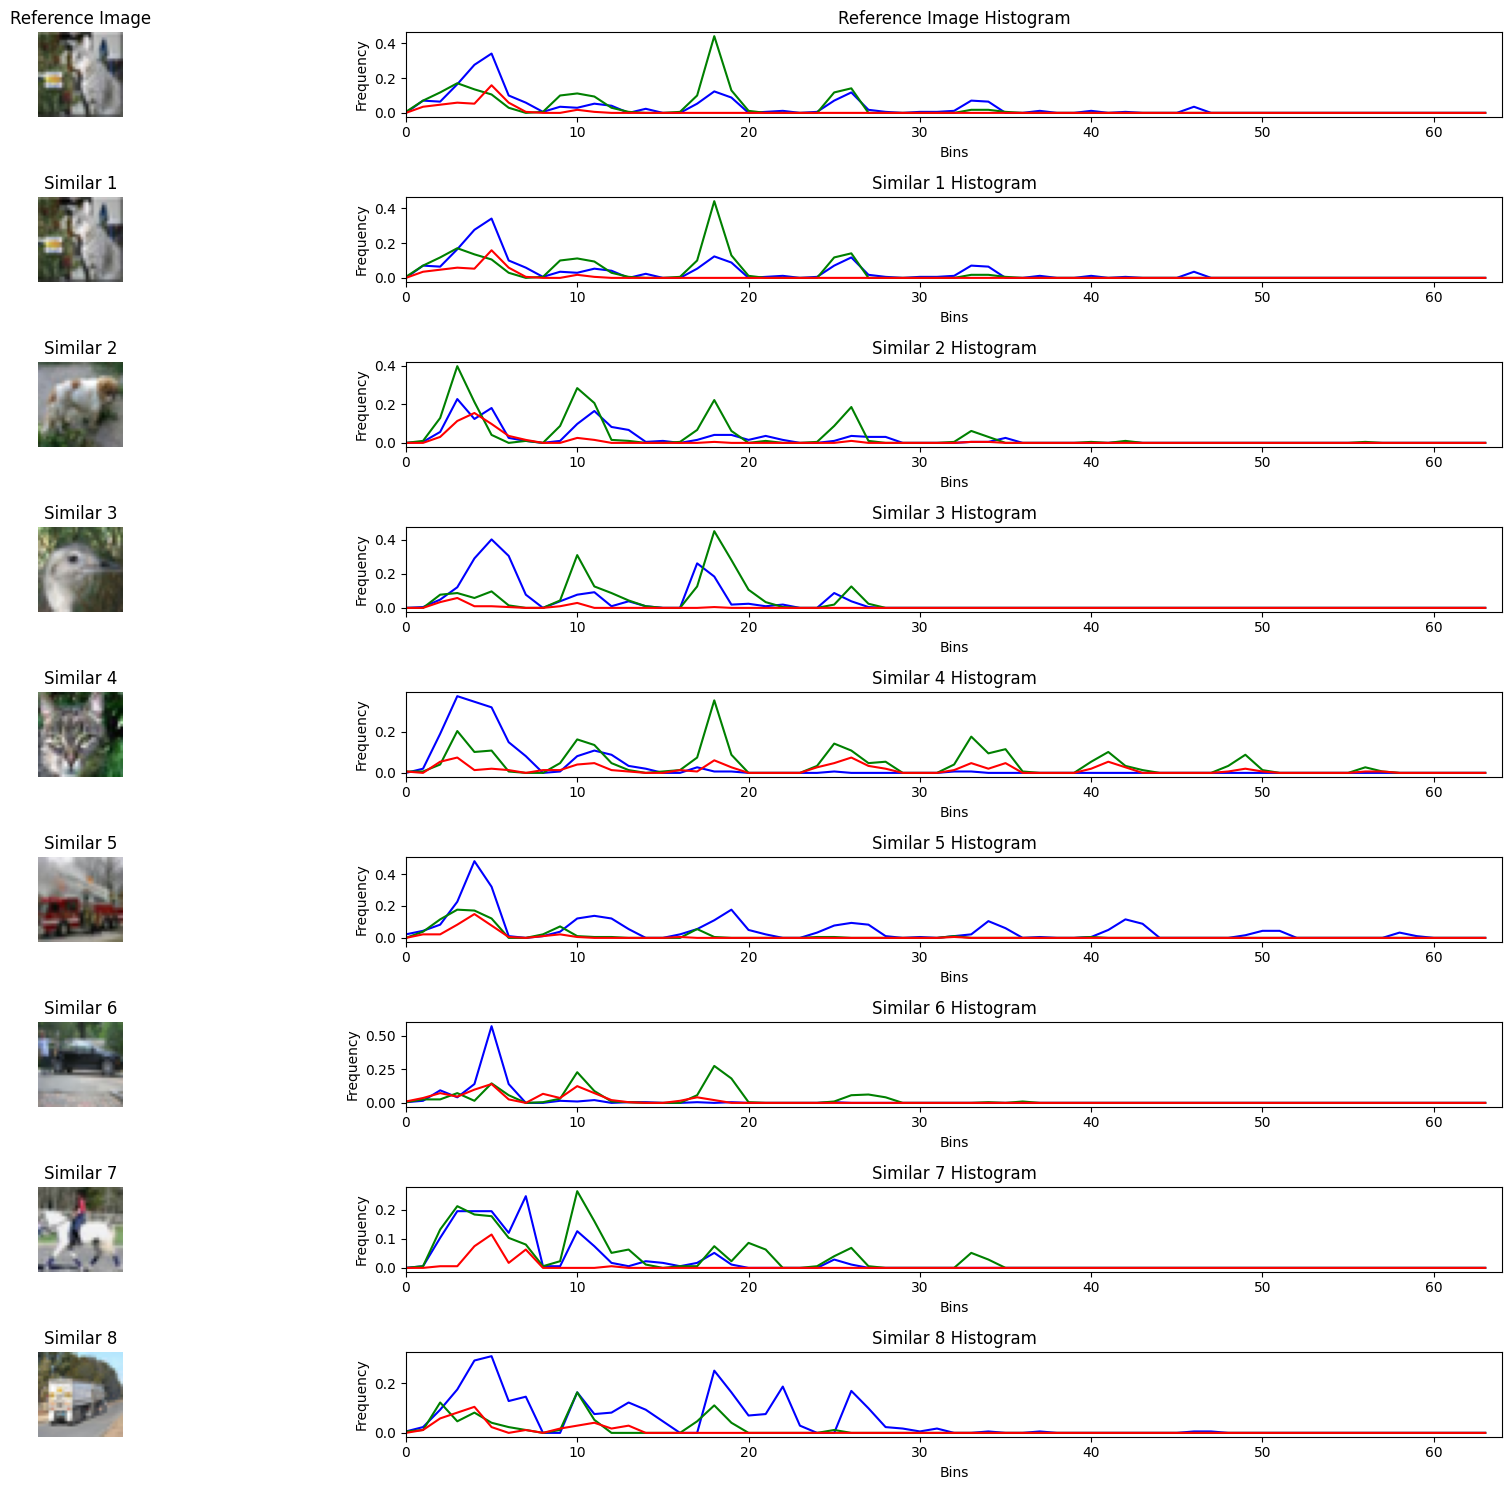

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

def extract_color_histogram(image, bins=(16, 16, 16), color_space='LAB'):
    if color_space == 'HSV':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LAB':
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    else:
        raise ValueError(f"Unsupported color space: {color_space}")

    hist = cv2.calcHist([converted_image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def find_similar_images(reference_image, data, labels, num_similar=8, bins=(8, 8, 8), color_space='LAB'):
    ref_hist = extract_color_histogram(reference_image, bins=bins, color_space=color_space)
    
    distances = []
    for i, hist in enumerate(data):
        dist = euclidean(ref_hist, hist)
        distances.append((dist, i))
    
    distances.sort()
    closest_indices = [index for _, index in distances[:num_similar]]
    
    similar_images = [images[i] for i in closest_indices]
    similar_labels = [labels[i] for i in closest_indices]
    
    return similar_images, similar_labels

def plot_images_and_histograms(reference_image, similar_images, similar_labels, bins=(8, 8, 8), color_space='LAB'):
    plt.figure(figsize=(20, 15))

    plt.subplot(len(similar_images) + 1, 2, 1)
    plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))
    plt.title("Reference Image")
    plt.axis('off')
    

    ref_hist = extract_color_histogram(reference_image, bins=bins, color_space=color_space)
    

    plt.subplot(len(similar_images) + 1, 2, 2)
    colors = ('b', 'g', 'r')
    for j, col in enumerate(colors):
        hist_part = ref_hist[j * bins[0] * bins[1]: (j + 1) * bins[0] * bins[1]]
        plt.plot(hist_part, color=col)
        plt.xlim([0, bins[0] * bins[1]])
    plt.title("Reference Image Histogram")
    plt.xlabel("Bins")
    plt.ylabel("Frequency")
    

    for i, (image, label) in enumerate(zip(similar_images, similar_labels), start=1):
        plt.subplot(len(similar_images) + 1, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Similar {i}")
        plt.axis('off')
        
        hist = extract_color_histogram(image, bins=bins, color_space=color_space)
        
        plt.subplot(len(similar_images) + 1, 2, 2 * i + 2)
        for j, col in enumerate(colors):
            hist_part = hist[j * bins[0] * bins[1]: (j + 1) * bins[0] * bins[1]]
            plt.plot(hist_part, color=col)
            plt.xlim([0, bins[0] * bins[1]])
        plt.title(f"Similar {i} Histogram")
        plt.xlabel("Bins")
        plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

bins = (8, 8, 8)
color_space = 'HSV'

dataset_path = "data/cifar-10-batches-py"
data, labels, images = load_cifar10_dataset(dataset_path, bins=bins, color_space=color_space)

# select reference image
reference_image = images[78]

# Find similar images
similar_images, similar_labels = find_similar_images(reference_image, data, labels, num_similar=8, bins=bins, color_space=color_space)

# Show the reference image and the similar images with their histograms

plot_images_and_histograms(reference_image, similar_images, similar_labels, bins=bins, color_space=color_space)


## Experiments



**More bins for the histogram**: 
Increasing the number of bins can improve the resolution of the colour histogram. 8,16,32


**Other colour spaces**:
In addition to the HSV colour space, try out other colour spaces such as LAB (or YUV)


## Application of shallow algorithms

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler


# split the dataset into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

# scale the features to the range [0, 1] 
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)

### Bins

In [15]:
bins_list = [(5,5,5), (8, 8, 8), (12,12,12),(16, 16, 16),(32, 32, 32)]
#bins_list = [(5,5,5), (8, 8, 8), (12,12,12)]
bins = (8, 8, 8)
results = {}

for bins in bins_list:
    data, labels, images = load_cifar10_dataset(dataset_path, bins=bins, color_space='HSV')
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.25, random_state=42)
    scaler = StandardScaler()
    trainX = scaler.fit_transform(trainX)
    testX = scaler.transform(testX)

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(trainX, trainY)
    rf_predictions = rf.predict(testX)
    
    accuracy = accuracy_score(testY, rf_predictions)
    results[bins] = accuracy
    print(f"Random Forest Accuracy with bins {bins}: {accuracy}")

# Best Bin configuration
best_bins = max(results, key=results.get)
print(f"Best bins configuration: {best_bins}")


Random Forest Accuracy with bins (5, 5, 5): 0.39392
Random Forest Accuracy with bins (8, 8, 8): 0.40736


KeyboardInterrupt: 

### Color Spaces



In [17]:
color_spaces = ['HSV', 'LAB']
bins = (8, 8, 8)
results = {}

for color_space in color_spaces:
    data, labels, images = load_cifar10_dataset(dataset_path, bins=bins, color_space=color_space)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.25, random_state=42)
    
    scaler = StandardScaler()
    trainX = scaler.fit_transform(trainX)
    testX = scaler.transform(testX)
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(trainX, trainY)
    
    rf_predictions = rf.predict(testX)
    accuracy = accuracy_score(testY, rf_predictions)
    
    results[color_space] = accuracy
    print(f"Random Forest Accuracy with bins {bins} and color space {color_space}: {accuracy}")

best_config = max(results, key=results.get)
print(f"Best color space configuration: {best_config}")

Random Forest Accuracy with bins (8, 8, 8) and color space HSV: 0.40664
Random Forest Accuracy with bins (8, 8, 8) and color space LAB: 0.394
Best color space configuration: HSV


## train and evaluate the shallow 

In [26]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score


### RF

In [27]:
np.random.seed(42)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainX, trainY)
rf_predictions = rf.predict(testX)
print("Random Forest Accuracy:", accuracy_score(testY, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(testY, rf_predictions))


f1 = f1_score(testY, rf_predictions, average='weighted')  # 'weighted' takes into account the class imbalances
print("Random Forest F1 Score:", f1)


Random Forest Accuracy: 0.39464
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.49      0.48      1235
           1       0.40      0.52      0.46      1212
           2       0.40      0.29      0.33      1270
           3       0.30      0.31      0.31      1291
           4       0.40      0.40      0.40      1182
           5       0.30      0.23      0.26      1263
           6       0.43      0.50      0.46      1219
           7       0.33      0.34      0.33      1259
           8       0.45      0.47      0.46      1280
           9       0.43      0.41      0.42      1289

    accuracy                           0.39     12500
   macro avg       0.39      0.40      0.39     12500
weighted avg       0.39      0.39      0.39     12500

Random Forest F1 Score: 0.39058435488617094


In [65]:
# set seed for reproducibility
# hyperparameter tuning for Random Forest


np.random.seed(42)
rf = RandomForestClassifier(n_estimators=1500, random_state=42, n_jobs=-1, min_samples_split = 3, min_samples_leaf = 1, max_depth = 35)
rf.fit(trainX, trainY)
rf_predictions = rf.predict(testX)
print("Random Forest Accuracy:", accuracy_score(testY, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(testY, rf_predictions))


f1 = f1_score(testY, rf_predictions, average='weighted')  # 'weighted' takes into account the class imbalances
print("Random Forest F1 Score:", f1)

Random Forest Accuracy: 0.41024
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50      1235
           1       0.43      0.54      0.48      1212
           2       0.42      0.29      0.34      1270
           3       0.31      0.31      0.31      1291
           4       0.43      0.40      0.41      1182
           5       0.33      0.22      0.27      1263
           6       0.43      0.53      0.48      1219
           7       0.34      0.38      0.36      1259
           8       0.45      0.49      0.47      1280
           9       0.45      0.45      0.45      1289

    accuracy                           0.41     12500
   macro avg       0.41      0.41      0.41     12500
weighted avg       0.41      0.41      0.41     12500

Random Forest F1 Score: 0.4052378563256921


### Optimization

#### Optimising parameters

In [68]:
param_grid = {
    'n_estimators': [100, 300, 1000],  
    'max_features': ['auto', 'sqrt', 'log2'],  
    'max_depth': [None, 20, 35, 40],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 4],  
    'bootstrap': [True] 
}

rf_grid = RandomForestClassifier()


grid_search = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(trainX, trainY)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model
rf_best = grid_search.best_estimator_
rf_predictions = rf_best.predict(testX)
print("Optimized Random Forest Accuracy:", accuracy_score(testY, rf_predictions))
print("Optimized Random Forest Classification Report:\n", classification_report(testY, rf_predictions))


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estim

/Users/paulbojan/Documents/TU Wien/2.Semester/Machine Learning/assignments/ex3/ml-ex3/env_ML3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  38.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  38.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  23.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  22.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  26.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_depth

/Users/paulbojan/Documents/TU Wien/2.Semester/Machine Learning/assignments/ex3/ml-ex3/env_ML3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
64 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/paulbojan/Documents/TU Wien/2.Semester/Machine Learning/assignments/ex3/ml-ex3/env_ML3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/paulbojan/Documents/TU Wien/2.Semester/Machine Learning/assignments/ex3/ml-ex3/env_ML3/lib/python3.11/site-packages/sklearn/base.py",

Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Optimized Random Forest Accuracy: 0.41104
Optimized Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.51      0.50      1235
           1       0.43      0.54      0.48      1212
           2       0.43      0.29      0.35      1270
           3       0.31      0.30      0.30      1291
           4       0.43      0.41      0.42      1182
           5       0.33      0.22      0.27      1263
           6       0.42      0.54      0.47      1219
           7       0.34      0.37      0.36      1259
           8       0.46      0.50      0.48      1280
           9       0.43      0.44      0.44      1289

    accuracy                           0.41     12500
   macro avg       0.41      0.41      0.41     12500
weighted avg       0.41      0.41      0.41     12

In [70]:
f1 = f1_score(testY, rf_predictions, average='weighted')  # 'weighted' takes into account the class imbalances
print("Random Forest F1 Score:", f1)

Random Forest F1 Score: 0.40555853074651677


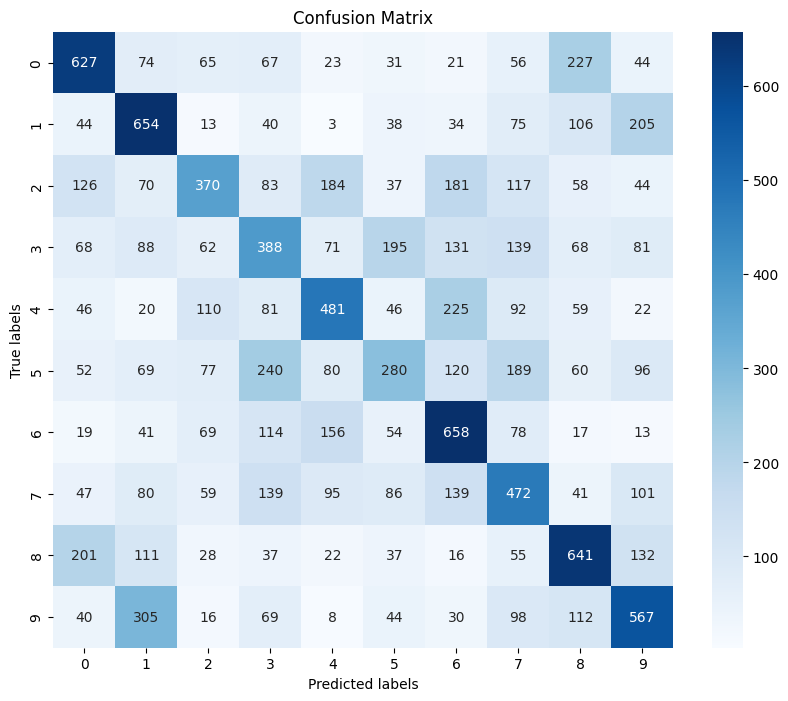

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rf_cm = confusion_matrix(testY, rf_predictions)

fmt = 'd'

plt.figure(figsize=(10, 8))
sns.heatmap(rf_cm, annot=True, cmap='Blues', fmt=fmt, xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
